CODE BLOCK: 1

In [1]:
import torch
import torch.nn as nnF
import torch.optim as optim
import torchvision
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision import datasets, transforms

CODE BLOCK: 2

In [2]:
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

CUDA Available? True


CODE BLOCK: 3

In [3]:
# Train data transformations
train_transforms = A.Compose([
    A.PadIfNeeded(min_height=36, min_width=36, always_apply=True, p=1),
    A.RandomCrop(height=32, width=32, always_apply=True, p=1),
    A.HorizontalFlip(p=0.5),
    A.CoarseDropout(max_holes=1, max_height=8, max_width=8, min_holes=1, min_height=8, min_width=8,always_apply=False,fill_value=(0.5, 0.5, 0.5)),
    A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ToTensorV2()
    ])

# Test data transformations
test_transforms = A.Compose([
    A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ToTensorV2()
    ])

CODE BLOCK: 4

In [4]:
# from utils import get_mnist_data
# train, test = get_mnist_data(train_transforms, test_transforms)
def get_augmentation(transforms):
    return lambda img: transforms(image=np.array(img))['image']
train = datasets.CIFAR10('./data', train=True, download=True, transform=get_augmentation(train_transforms))
test = datasets.CIFAR10('./data', train=False, download=True, transform=get_augmentation(test_transforms))

Files already downloaded and verified
Files already downloaded and verified


CODE BLOCK: 5

In [5]:
batch_size = 512

kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 4, 'pin_memory': True}

train_loader = torch.utils.data.DataLoader(train, **kwargs)
test_loader = torch.utils.data.DataLoader(test, **kwargs)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


CODE BLOCK: 7

In [7]:
from model import model_10

CODE BLOCK: 8

In [8]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

CODE BLOCK: 9

In [9]:
from utils import train, test
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = model_10().to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
              ReLU-2           [-1, 64, 32, 32]               0
       BatchNorm2d-3           [-1, 64, 32, 32]             128
           Dropout-4           [-1, 64, 32, 32]               0
            Conv2d-5          [-1, 128, 32, 32]          73,728
         MaxPool2d-6          [-1, 128, 16, 16]               0
              ReLU-7          [-1, 128, 16, 16]               0
       BatchNorm2d-8          [-1, 128, 16, 16]             256
           Dropout-9          [-1, 128, 16, 16]               0
           Conv2d-10          [-1, 128, 16, 16]         147,456
             ReLU-11          [-1, 128, 16, 16]               0
      BatchNorm2d-12          [-1, 128, 16, 16]             256
          Dropout-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1, 128,

In [10]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")
model = model_10().to(device)
from torch.optim.lr_scheduler import OneCycleLR
criterion = nnF.CrossEntropyLoss(reduction="sum")
!pip install torch-lr-finder


  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 7.06E-02


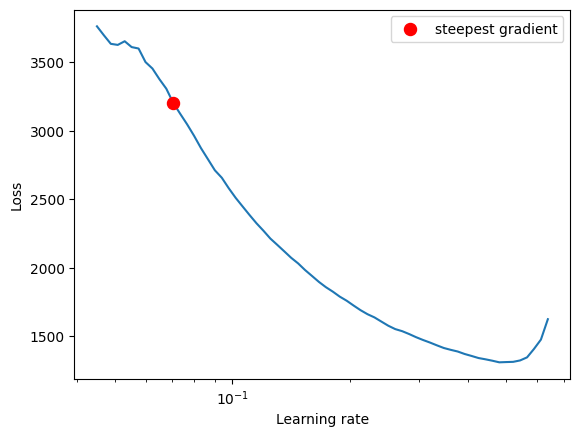

In [21]:
from torch_lr_finder import LRFinder

model =  model_10().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.03, weight_decay=1e-4)
criterion = nnF.CrossEntropyLoss(reduction="sum")
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=100, num_iter=200, step_mode="exp")
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset()

CODE BLOCK: 10

In [24]:
optimizer = optim.Adam(model.parameters(), lr=8E-04)
num_epochs = 24
scheduler = OneCycleLR(
    optimizer,
    max_lr = 7.06E-02,
    steps_per_epoch = len(train_loader),
    epochs = num_epochs,
    pct_start = 5/num_epochs,
    div_factor = 100,
    three_phase = False,
    final_div_factor = 100
)


for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  model, train_losses, train_acc = train(model, device, train_loader, optimizer, train_losses, train_acc, scheduler, criterion)
  model, test_losses, test_acc = test(model, device, test_loader, test_losses, test_acc, criterion)
  # scheduler.step()

Epoch 1


Loss=340.2367248535156 Batch_id=97 Accuracy=62.57: 100%|██████████| 98/98 [00:20<00:00,  4.82it/s]



Test set: Average loss: 1.2272, Accuracy: 6391/10000 (63.91%)

Epoch 2


Loss=317.7380065917969 Batch_id=97 Accuracy=67.15: 100%|██████████| 98/98 [00:20<00:00,  4.78it/s]



Test set: Average loss: 1.1843, Accuracy: 6671/10000 (66.71%)

Epoch 3


Loss=220.99615478515625 Batch_id=97 Accuracy=72.94: 100%|██████████| 98/98 [00:21<00:00,  4.53it/s]



Test set: Average loss: 0.6806, Accuracy: 7696/10000 (76.96%)

Epoch 4


Loss=214.72445678710938 Batch_id=97 Accuracy=76.85: 100%|██████████| 98/98 [00:20<00:00,  4.69it/s]



Test set: Average loss: 0.8139, Accuracy: 7572/10000 (75.72%)

Epoch 5


Loss=200.56549072265625 Batch_id=97 Accuracy=79.43: 100%|██████████| 98/98 [00:21<00:00,  4.64it/s]



Test set: Average loss: 0.7260, Accuracy: 7639/10000 (76.39%)

Epoch 6


Loss=175.2460479736328 Batch_id=97 Accuracy=79.70: 100%|██████████| 98/98 [00:20<00:00,  4.70it/s]



Test set: Average loss: 0.6587, Accuracy: 7881/10000 (78.81%)

Epoch 7


Loss=174.2267303466797 Batch_id=97 Accuracy=82.67: 100%|██████████| 98/98 [00:20<00:00,  4.68it/s]



Test set: Average loss: 0.5610, Accuracy: 8418/10000 (84.18%)

Epoch 8


Loss=149.08322143554688 Batch_id=97 Accuracy=84.15: 100%|██████████| 98/98 [00:21<00:00,  4.54it/s]



Test set: Average loss: 0.7798, Accuracy: 7839/10000 (78.39%)

Epoch 9


Loss=132.74310302734375 Batch_id=97 Accuracy=85.06: 100%|██████████| 98/98 [00:21<00:00,  4.57it/s]



Test set: Average loss: 0.5917, Accuracy: 8307/10000 (83.07%)

Epoch 10


Loss=139.7842559814453 Batch_id=97 Accuracy=86.35: 100%|██████████| 98/98 [00:21<00:00,  4.58it/s]



Test set: Average loss: 0.4893, Accuracy: 8518/10000 (85.18%)

Epoch 11


Loss=164.9254913330078 Batch_id=97 Accuracy=87.18: 100%|██████████| 98/98 [00:21<00:00,  4.61it/s]



Test set: Average loss: 0.5550, Accuracy: 8410/10000 (84.10%)

Epoch 12


Loss=106.7568588256836 Batch_id=97 Accuracy=88.53: 100%|██████████| 98/98 [00:21<00:00,  4.60it/s]



Test set: Average loss: 0.4225, Accuracy: 8701/10000 (87.01%)

Epoch 13


Loss=125.42279815673828 Batch_id=97 Accuracy=89.57: 100%|██████████| 98/98 [00:22<00:00,  4.39it/s]



Test set: Average loss: 0.3620, Accuracy: 8888/10000 (88.88%)

Epoch 14


Loss=79.91839599609375 Batch_id=97 Accuracy=90.42: 100%|██████████| 98/98 [00:21<00:00,  4.46it/s]



Test set: Average loss: 0.3579, Accuracy: 8893/10000 (88.93%)

Epoch 15


Loss=86.99488830566406 Batch_id=97 Accuracy=91.87: 100%|██████████| 98/98 [00:21<00:00,  4.55it/s]



Test set: Average loss: 0.3208, Accuracy: 9008/10000 (90.08%)

Epoch 16


Loss=62.060791015625 Batch_id=97 Accuracy=92.61: 100%|██████████| 98/98 [00:21<00:00,  4.59it/s]



Test set: Average loss: 0.3515, Accuracy: 8980/10000 (89.80%)

Epoch 17


Loss=51.33816146850586 Batch_id=97 Accuracy=93.58: 100%|██████████| 98/98 [00:21<00:00,  4.50it/s]



Test set: Average loss: 0.3655, Accuracy: 9069/10000 (90.69%)

Epoch 18


Loss=55.26064682006836 Batch_id=97 Accuracy=94.66: 100%|██████████| 98/98 [00:21<00:00,  4.55it/s]



Test set: Average loss: 0.2889, Accuracy: 9158/10000 (91.58%)

Epoch 19


Loss=42.55610656738281 Batch_id=97 Accuracy=95.44: 100%|██████████| 98/98 [00:21<00:00,  4.57it/s]



Test set: Average loss: 0.2798, Accuracy: 9198/10000 (91.98%)

Epoch 20


Loss=35.581050872802734 Batch_id=97 Accuracy=95.82: 100%|██████████| 98/98 [00:21<00:00,  4.49it/s]



Test set: Average loss: 0.2720, Accuracy: 9213/10000 (92.13%)

Epoch 21


Loss=42.7068977355957 Batch_id=97 Accuracy=96.52: 100%|██████████| 98/98 [00:21<00:00,  4.46it/s]



Test set: Average loss: 0.2679, Accuracy: 9245/10000 (92.45%)

Epoch 22


Loss=29.133487701416016 Batch_id=97 Accuracy=96.98: 100%|██████████| 98/98 [00:21<00:00,  4.54it/s]



Test set: Average loss: 0.2637, Accuracy: 9254/10000 (92.54%)

Epoch 23


Loss=25.283205032348633 Batch_id=97 Accuracy=97.20: 100%|██████████| 98/98 [00:21<00:00,  4.57it/s]



Test set: Average loss: 0.2827, Accuracy: 9262/10000 (92.62%)

Epoch 24


Loss=19.5598087310791 Batch_id=97 Accuracy=97.20: 100%|██████████| 98/98 [00:21<00:00,  4.54it/s]



Test set: Average loss: 0.2620, Accuracy: 9270/10000 (92.70%)



CODE BLOCK: 11

Text(0.5, 1.0, 'Test Accuracy')

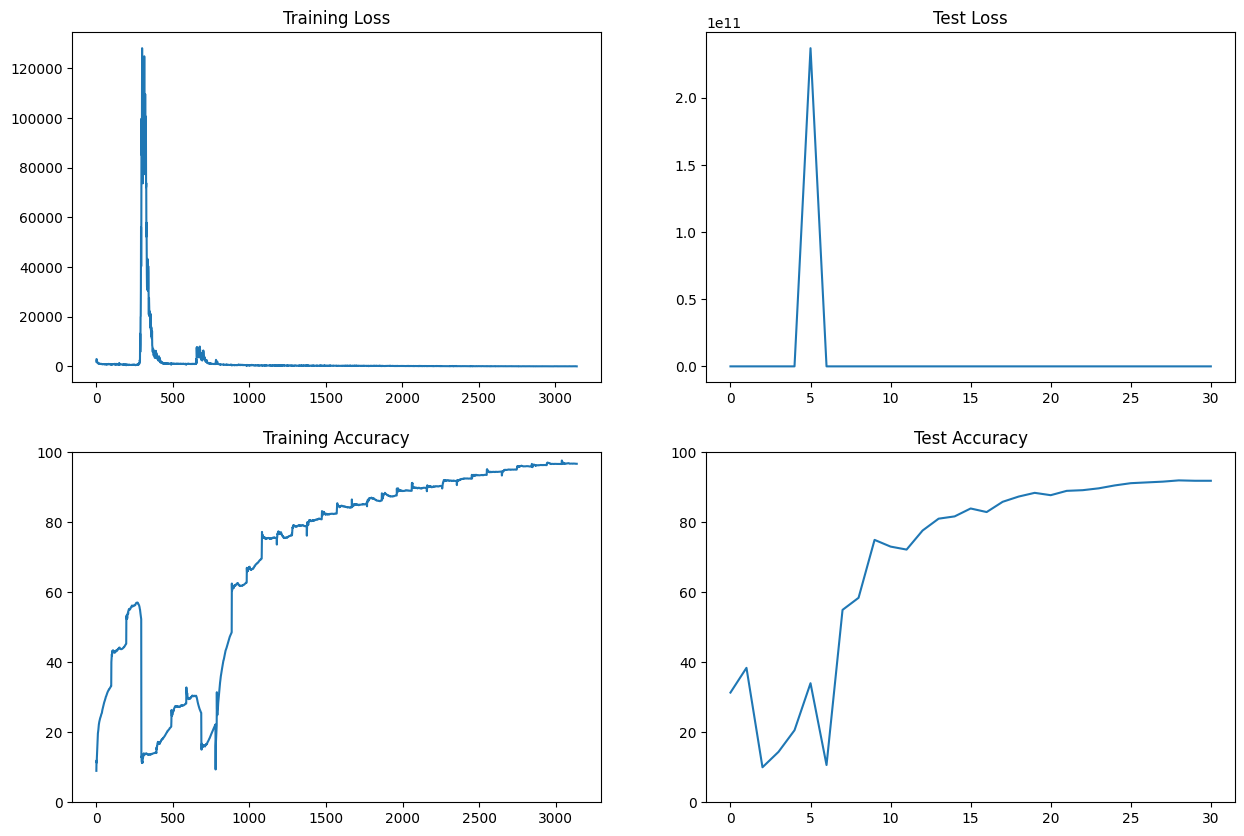

In [22]:
# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot([x.cpu().item() for x in train_losses])
axs[0, 0].set_title("Training Loss")
axs[1,0].axis(ymin=0,ymax=100)
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1,1].axis(ymin=0,ymax=100)
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")
